<a href="https://colab.research.google.com/github/kenneth-craig/academyPub/blob/main/ML-XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
#upload sonar.csv file from local drive and import file
# load and summarize the sonar dataset
!pip install pickle-mixin
import pickle
import joblib
from google.colab import files

file = files.upload()

In [49]:
!pwd
!ls

/content
'pima-indians-diabetes.data (1).csv'   pima.joblib.dat	 sample_data
 pima-indians-diabetes.data.csv        pima.model.dat


# Evaluating XGBoost With K-Fold Cross-Validation
**Overfitting** occurs where the model fits the data too well. Overfitting a model results in good accuracy for training data set but poor results on new data sets.

**Underfitting** occurs when the machine learning algorithm cannot capture the underlying trend of the data where the model does not fit the data well enough as a result of:
i) Missing data is not handled

ii) No outlier treatment

iii) Removal of features that do not contribute much to the predictor variable

In [14]:
 from numpy import loadtxt
 from xgboost import XGBClassifier
 from sklearn.model_selection import StratifiedKFold
 from sklearn.model_selection import cross_val_score

 # load data
 ds = loadtxt('pima-indians-diabetes.data.csv', delimiter=',')

# & is column 8 transposed
X = ds[:,0:8]
Y = ds[:,8]

# K-Fold Cross Validation
# Note: Stratified gives better Standard Variation than standard Cross Validation because of better distribution of classifications
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(model, X, Y, cv=kfold)

# Evaluate prediction
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Accuracy: 76.95% (5.88%)


# Simple XGBoost Problem
**Using pima indians diabetes dataset**

Added Model Selection by Feature Importance Importance
and ability to Save Model for later use and plots of model
and early stop to prevent overfitting


[0]	validation_0-error:0.22179	validation_0-logloss:0.655153	validation_1-error:0.259843	validation_1-logloss:0.660186
[1]	validation_0-error:0.202335	validation_0-logloss:0.623322	validation_1-error:0.26378	validation_1-logloss:0.634854
[2]	validation_0-error:0.196498	validation_0-logloss:0.596814	validation_1-error:0.26378	validation_1-logloss:0.61224
[3]	validation_0-error:0.200389	validation_0-logloss:0.574027	validation_1-error:0.255906	validation_1-logloss:0.593118
[4]	validation_0-error:0.202335	validation_0-logloss:0.553853	validation_1-error:0.255906	validation_1-logloss:0.578303
[5]	validation_0-error:0.202335	validation_0-logloss:0.536789	validation_1-error:0.26378	validation_1-logloss:0.564942
[6]	validation_0-error:0.194553	validation_0-logloss:0.521477	validation_1-error:0.23622	validation_1-logloss:0.555113
[7]	validation_0-error:0.200389	validation_0-logloss:0.507802	validation_1-error:0.255906	validation_1-logloss:0.54499
[8]	validation_0-error:0.194553	validation_0-lo

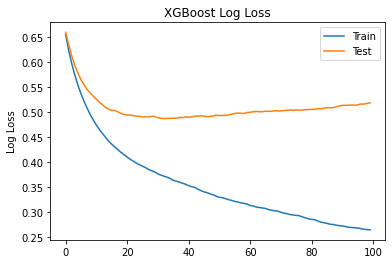

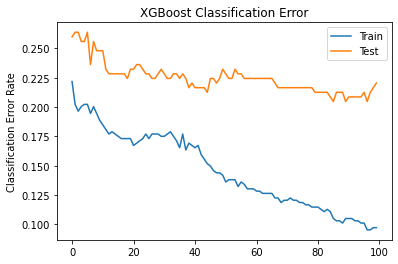

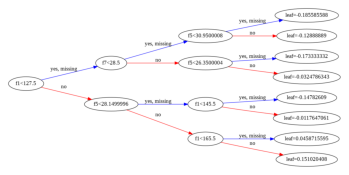

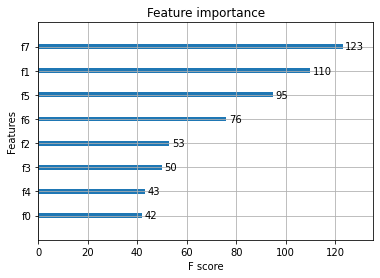

[0.0775613  0.29183695 0.08493615 0.08040861 0.09472006 0.15973376
 0.1021471  0.10865614]
Thresh=0.078, n=8, New Accuracy: 77.95%
Thresh=0.080, n=7, New Accuracy: 76.38%
Thresh=0.085, n=6, New Accuracy: 77.56%
Thresh=0.095, n=5, New Accuracy: 76.38%
Thresh=0.102, n=4, New Accuracy: 76.38%
Thresh=0.109, n=3, New Accuracy: 74.80%
Thresh=0.160, n=2, New Accuracy: 75.98%
Thresh=0.292, n=1, New Accuracy: 70.08%


In [76]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from xgboost import plot_tree
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel

ds = np.loadtxt('/content/pima-indians-diabetes.data.csv', delimiter=',')

# Split into X & Y datset
# X is columns 0..7
# & is column 8 transposed
X = ds[:,0:8]
Y = ds[:,8]

# Split into TRAIN & TEST datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

#fit model on training data
eval_set = [(X_train, y_train), (X_test, y_test)]
model = XGBClassifier()
model.fit(X_train, y_train, eval_set=eval_set, eval_metric=["error", "logloss"], verbose=True)

# make predictions for the test data
predictions = model.predict(X_test)

# evaluation predictions
accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy: %.2f%%" % (accuracy * 100))

# Retieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# Plot logloss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

# Plot Classification Error Rate
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error Rate')
pyplot.title('XGBoost Classification Error')
pyplot.show()

# Plot Decision Tree for model[0], can also be plotted for all other interations of XGBoost
plot_tree(model, num_trees=0, rankdir='LR')
pyplot.show()

# Plot Feature Importance
plot_importance(model)
#pyplot.bar(range(len(model.feature_importances_)) ,model.feature_importances_)
pyplot.show()
print(model.feature_importances_)

# Tune model using xgboost Feature Selection
thresholds = np.sort(model.feature_importances_)

for thresh in thresholds:
  # Select features using threshold
  selection = SelectFromModel(model, threshold=thresh, prefit=True)
  sub_X_train = selection.transform(X_train)
  # train model
  sub_model = XGBClassifier()
  sub_model.fit(sub_X_train, y_train)
  #evaluate model
  sub_X_test = selection.transform(X_test)
  new_predictions = sub_model.predict(sub_X_test)
  new_accuracy = accuracy_score(y_test, new_predictions)
  print("Thresh=%.3f, n=%d, New Accuracy: %.2f%%" % (thresh, sub_X_train.shape[1], new_accuracy*100))

# Save model to file for later use
# Save using pickle library
#pickle.dump(model, open('pima.model.dat', 'wb'))
# Save using Joblib library - may be more efficient for larger libraries
#joblib.dump(model, "pima.joblib.dat")
#print("Saved model to: pima.model.dat")

In [ ]:
rly Stopping

**Early Stopping Parameters With XGBoost Determined in Above Example**

# Using XGBoost to Predict Iris flower
**Simple Label Encoding on Output**

In [ ]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

#load dataset
df = pd.read_csv('iris.csv', header=None)
ds = df.values

# Split the data into X and Y
X = ds[:,0:4]
Y = ds[:,4]

# Encode string class values as integers
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y)
le_y = label_encoder.transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, le_y, test_size=0.33, random_state=7)

# Fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)

#make predictions for test data
y_predictions = model.predict(X_test)

# Evaluate predictions
accuracy = accuracy_score(y_test, y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100))



Accuracy: 92.00%


# XGBoost with Categorical Data
**One Hot Encoding**

In [ ]:
import pandas as pd
from numpy import column_stack
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# Load data
df = pd.read_csv('/content/datasets-uci-breast-cancer.csv', header=None)

ds = df.values

# split into X & y
X = ds[:,0:9]
X = X.astype(str)
y = ds[:,9]

# Encode string input values as integers
columns = []
for i in range(0, X.shape[1]):
  label_encoder = LabelEncoder()
  feature = label_encoder.fit_transform(X[:,i])
  feature = feature.reshape(X.shape[0], 1)
  # print("feature_shape before onehot: ", feature.shape)
  onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
  feature = onehot_encoder.fit_transform(feature)
  print("feature_shape after onehot: ", feature.shape)
  columns.append(feature)
  
# collapse columns into array
encoded_x = column_stack(columns)
print("encoded X shape: ", encoded_x.shape)

# encoding string class values as integers
label_encoder = LabelEncoder()
label_encoded_y = label_encoder.fit_transform(y)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(encoded_x, label_encoded_y, test_size=0.33, random_state=7)

# fit model on training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_predictions = model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


feature_shape after onehot:  (286, 6)
feature_shape after onehot:  (286, 3)
feature_shape after onehot:  (286, 11)
feature_shape after onehot:  (286, 7)
feature_shape after onehot:  (286, 3)
feature_shape after onehot:  (286, 3)
feature_shape after onehot:  (286, 2)
feature_shape after onehot:  (286, 6)
feature_shape after onehot:  (286, 2)
encoded X shape:  (286, 43)
XGBClassifier()
Accuracy: 71.58%


In [ ]:
# Method for obtaining unique values for categories
list_col = df.columns.tolist()
for col in list_col:
   i = df.iloc[:,col].unique()
   print (col, ':- ', i)

In [ ]:
# Simplar code as above but used OrdinalLabeling for Age of person instead of OneHot and Accuracy results went down by 1%
import pandas as pd
from numpy import column_stack
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Load data
df = pd.read_csv('/content/datasets-uci-breast-cancer.csv', header=None)

ds = df.values

# split into X & y
X = ds[:,0:9]
X = X.astype(str)
y = ds[:,9]

# Encode string input values as integers
t = [('OrdAge', OrdinalEncoder(), [0]), ('hot', OneHotEncoder(), [1,2,3,4,5,6,7,8])]

transform = ColumnTransformer(transformers=t)

# transform the training data
encoded_x = transform.fit_transform(X)

# encode y output
label_encoder = LabelEncoder()
label_encoded_y = label_encoder.fit_transform(y)

# Create train/test dataset
X_train, X_test, y_train, y_test = train_test_split(encoded_x, label_encoded_y, test_size=0.33, random_state=7)

# Fit model on Training data
model = XGBClassifier();
model.fit(X_train, y_train)
print(model)

# Evaluate model
y_predictions = model.predict(X_test)

#evaluate predictions
accuracy = accuracy_score(y_test, y_predictions)
print("Accuracy %.2f%%" % (accuracy * 100))

XGBClassifier()
Accuracy 70.53%


In [ ]:
# UNFINISHED CODE - Same code as above but trying to get it working using Pythonic with a For Next loop but didn't get it finished
import pandas as pd
from numpy import column_stack
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

# Load data
df = pd.read_csv('/content/datasets-uci-breast-cancer.csv', header=None)

ds = df.values

# split into X & y
X = ds[:,0:9]
X = X.astype(str)
Y = ds[:,9]

# Encode string input values as integers
t[0] = 'OrdAge', OrdinalEncoder(), [0]

t[1] "'hot', OneHotEncoder(), [1,2,3,4,5,6,7,8]"
t[1] = t1
t1 = "'hot', OneHotEncoder(), ["

for i in range (1, X.shape[1]):
  t1 = t1 + str(i)
  print(t1)

t1 = t1 + X.shape[1] + ']'
print(t1)

transform = ColumnTransformer(transformers=t)

# transform the training data
X_encoded = transformer.fit_transform(X)

# encode y output
label_encoder = LabelEncoder()
label_encoded_y = label_encoder.fit_transform(y)

# Create train/test dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, label_encoded_y, test_size=0.33, random_state=7)

# Fit model on Training data
model = XGBClassifier();
model.fit(X_train, y_train)
print(model)

# Evaluate model
y_predictions = model.predict(X_test)

#evaluate predictions
accuracy = accuracy_score(y_test, y_predictions)
print("%.2f%%" % (accuracy * 100))

In [ ]:
# UNFINISHED CODE: For Next loop to build command for COLUMN_TRANSFORMATION for OneHot Encoding all columns

from numpy import array

# Encode string input values as integers

t = []
#t[0] = 'OrdAge', OrdinalEncoder(), [0]

# format of t[1] = 'hot', OneHotEncoder(), [1,2,3,4,5,6,7,8]

t1 = "('hot', OneHotEncoder(), ["

for i in range (1, X.shape[1]):
  t1 = t1 + str(i)
  
  if i != X.shape[1]-1:
    t1 = t1 + ','
  print(t1)

t1 = t1 + ']'
print(t1)

t[0] = ('OrdAge', OrdinalEncoder(), [0])
print('value of t0: ', t[0])
#print(type of )
print('value of t1: ', t[1])

print('value of t', t)

**XGBoost Example of Handling Missing Data**
XGBoost was designed to work with Sparse & Missing Data

In [ ]:
# XGBoost Example With Missing Data
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load dataframe
df = pd.read_csv("horse-colic.csv", delim_whitespace=True, header=None)

ds = df.values

# Split into X and y
X = ds[:,0:27]
Y = ds[:,27]

# Set missing values to NaN.
# Setting the value to NaN instead of 0 sees the accuracy score lift by 2% from 83.84% to 85.86%
# Imputing with the mean or medium saw the accuracy reduce to 79.80%, the same as setting this value to 1 instead of setting it to 0
X[X == '?'] = 0

# Also covert data set to Numeric instead of String data type
X = X.astype('float32')

# Encoded y class values as 0 & 1 integers using Label Encoder
label_encoder = LabelEncoder()
label_encoded_y = label_encoder.fit_transform(Y)

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=0.33, random_state=7)

# Fit model on Training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

# Make predictions for Test data
predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy %.2f%%" % (accuracy * 100))



XGBClassifier()
Accuracy 83.84%
